In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.modeling import Sam
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import random

In [67]:
class MedSAM_TTA(nn.Module):
    def __init__(self, sam_checkpoint, model_type="vit_b", k = 4, iterations = 1, lr = 1e-4 , lambda_weight = 1e3):
        super().__init__()
        
        # Load SAM model
        self.sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.sam.to(self.device)
        
        self.k = k
        self.iterations = iterations
        self.lambda_weight = lambda_weight
        self.learning_rate = lr
        # Freeze all components
        self._freeze_components()
        
    def _freeze_components(self):
        """Freeze image encoder, prompt encoder, and mask decoder"""
        # Freeze image encoder
        for param in self.sam.image_encoder.parameters():
            param.requires_grad = False
        
        # Freeze prompt encoder
        for param in self.sam.prompt_encoder.parameters():
            param.requires_grad = False
        
        # Freeze mask decoder
        for param in self.sam.mask_decoder.parameters():
            param.requires_grad = False
        
        print("✓ Image Encoder frozen")
        print("✓ Prompt Encoder frozen")
        print("✓ Mask Decoder frozen")
    
    def extract_features(self, image):
        """
        Extract features from the image encoder.
        
        Args:
            image: Preprocessed image tensor [B, 3, 1024, 1024]
        
        Returns:
            image_embeddings: Encoder features [B, 256, 64, 64]
        """
        self.image = image
        print(f'image shape:{image.shape}')
        with torch.no_grad():
            image_embeddings = self.sam.image_encoder(image)
        print(image_embeddings.shape)
        return image_embeddings
    def receptive_field(self,row,column,kernel = 16):
        return torch.tensor(self.image[:,:,row:row+kernel,column:column+kernel].flatten())
        
    def random_sample(self,box):
        coords = [(x, y) for x in range(64) for y in range(64)]
        coords_arr = np.array(coords).reshape(64, 64, 2)
        if box is None:
            cords = coords_arr.reshape(-1, 2).tolist()
            random.seed(23)
            sampled_coords = random.sample(cords, self.k)
            pairs = list(combinations(sampled_coords, 2))
            pairs = torch.tensor(pairs, dtype=torch.int32)
            # print(pairs)
            self.combinations = pairs
            return 
        else:
            #rejecting all the coordinates outside the bounding box region
            r1, c1 = box[0]
            r2, c2 = box[1]
            
            r1, r2 = sorted([np.floor(r1/16), np.floor(r2/16)])
            c1, c2 = sorted([np.floor(c1/16), np.floor(c2/16)])
            r1,r2,c1,c2 = int(r1), int(r2), int(c1),int(c2)
            cords = coords_arr[r1:r2,c1:c2].reshape(-1, 2).tolist()
            random.seed(23)
            
            print(self.k)
            sampled_coords = random.sample(cords, self.k)
            pairs = list(combinations(sampled_coords, 2))
            pairs = torch.tensor(pairs, dtype=torch.int32)
            # print(pairs)
            self.combinations = pairs
            return
    
    def gaussian_kernel(self,x, y, sigma):
        """
        Computes Gaussian RBF kernel matrix between x and y.
        x: (N, 1)
        y: (M, 1)
        """
        x = x.unsqueeze(1)          # (N, 1, 1)
        y = y.unsqueeze(0)          # (1, M, 1)
        diff = x - y                # (N, M, 1)
        return torch.exp(-torch.sum(diff ** 2, dim=-1) / (2 * sigma ** 2))  # (N, M)
    
    
    def mmd(self,x, y, sigma=1.0):
        x = x.float().view(-1, 1)
        y = y.float().view(-1, 1)
    
        Kxx = self.gaussian_kernel(x, x, sigma)
        Kyy = self.gaussian_kernel(y, y, sigma)
        Kxy = self.gaussian_kernel(x, y, sigma)
    
        mmd2 = Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()
        return torch.sqrt(torch.relu(mmd2))
    def dal_crf(self):
        loss = 0
        for i in self.combinations:
            # print(f'i[0]: {i[0]}')
            r1,c1 = i[0,0],i[0,1]
            r2,c2 = i[1,0],i[1,1]
            embed1 = self.image_embed[:,:,r1,c1]
            embed2 = self.image_embed[:,:,r2,c2]
            rf1 = self.receptive_field(r1,c1)
            rf2 = self.receptive_field(r2,c2)
            # print(f'embed1:{embed1}')
            # print(f'rf1:{rf1}')
            MMD_rf = self.mmd(rf1,rf2) #MMD between the receptive fields
            fro_norm = torch.norm(embed1 - embed2, p= 'fro') # fro norm for the image embeddings
            loss += ((1/2)*(MMD_rf)*(torch.exp(fro_norm)))
        loss_dal_crf = loss/self.k
        print(f'Loss DAL-CRF: {loss_dal_crf}')
        return loss_dal_crf

    
    def calculate_entropy(self, mask_logits):
        """
        Calculate pixel-wise entropy from mask logits.
        
        Args:
            mask_logits: Raw mask predictions (logits) [B, N, H, W]
        
        Returns:
            entropy: Pixel-wise entropy [B, N, H, W]
            mean_entropy: Mean entropy per mask [B, N]
            total_entropy: Total entropy per batch [B]
        """
        # Convert logits to probabilities
        probs = torch.sigmoid(mask_logits)
        # Create mask for high confidence pixels (prob > 0.95)
        high_conf_mask = probs > 0.95
        
        # Calculate binary entropy: -[p*log(p) + (1-p)*log(1-p)]
        # Add small epsilon to avoid log(0)
        eps = 1e-7
        probs_clipped = torch.clamp(probs, eps, 1 - eps)
        
        # Binary entropy formula
        entropy = -(probs_clipped * torch.log(probs_clipped) + 
                   (1 - probs_clipped) * torch.log(1 - probs_clipped))
        
        # Zero out entropy for pixels below threshold
        entropy = entropy * high_conf_mask.float()
        # print(f'Entropy: {entropy.shape}')
        total_entropy = entropy.sum(dim=(-2, -1))   # Total per mask [B, N]
        self.total_entropy = total_entropy
        print(f'Loss EM: {total_entropy.sum()}')
        return total_entropy
    def loss_calc(self,mask_logits):
        loss_dal_crf = self.dal_crf()
        loss_em = self.calculate_entropy(mask_logits)
        final_loss = loss_dal_crf.sum() + self.lambda_weight * loss_em.sum()# L_dal_crf + lambda*L_em
        print(f'Final_Loss: {final_loss}')
        # final_loss = torch.sum(loss_dal_crf,torch.tensor(self.lambda_weight*loss_em)) 
        return final_loss
    def params_pred(self,masks):
        probs = torch.sigmoid(masks)
        high_conf_mask = probs > 0.95
        high_conf_mask_int = high_conf_mask.int()
        
        num_foreground = high_conf_mask_int.sum().item()
        total_pixels = high_conf_mask.numel()
        fe = float(num_foreground)/total_pixels
        
        #lr interpolation based on foreground ratio
        low, high = 0.05, 0.2
        low_lr,high_lr = 1e-1,5e2
        if fe < low:
            te = low_lr
        elif fe > high:
            te = high_lr
        else:
            # linear interpolation between x and y
            t = (fe - low) / (high - low)  # normalized position [0,1]
            te = low_lr + t * (high_lr - low_lr)
        lr = torch.tensor(te)
        self.learning_rate = lr
        
        
    
    def predict_masks(self, image_embeddings, point_coords=None, point_labels=None, 
                     box=None, mask_input=None, multimask_output=True, 
                     return_logits=True, calculate_metrics=True):
        """
        Generate masks using manipulated features and prompt encoder.
        
        Args:
            image_embeddings: Manipulated encoder features [B, 256, 64, 64]
            point_coords: Point prompts [B, N, 2]
            point_labels: Point labels [B, N]
            box: Box prompts [B, 4]
            mask_input: Mask input [B, 1, 256, 256]
            multimask_output: Whether to output multiple masks
            return_logits: Whether to return raw logits
            calculate_metrics: Whether to calculate confidence metrics
        
        Returns:
            masks: Predicted masks (binary or probabilities) [B, N, H, W]
            iou_predictions: IOU predictions [B, N]
            low_res_masks: Low resolution masks [B, N, 256, 256]
            metrics: Confidence metrics (if calculate_metrics=True)
        """
        with torch.no_grad():
            # Prepare prompts using frozen prompt encoder
            sparse_embeddings, dense_embeddings = self.sam.prompt_encoder(
                points=(point_coords, point_labels) if point_coords is not None else None,
                boxes=box,
                masks=mask_input,
            )
            
            # Generate masks using frozen mask decoder
            low_res_masks, iou_predictions = self.sam.mask_decoder(
                image_embeddings=image_embeddings,
                image_pe=self.sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=multimask_output,
            )
            
            # Upscale masks to original resolution
            masks = self.sam.postprocess_masks(
                low_res_masks,
                input_size=(1024, 1024),
                original_size=(1024, 1024)
            )
            
            
            # Convert to binary masks if not returning logits
            if not return_logits:
                masks = (masks > 0.0).float()
        

        return masks, iou_predictions, low_res_masks
    
    def forward(self, image, manipulation_fn=None, point_coords=None, 
                point_labels=None, box=None, multimask_output=True):
        """
        Full forward pass: extract features -> manipulate -> predict masks
        
        Args:
            image: Input image [B, 3, 1024, 1024]
            manipulation_fn: Function to manipulate encoder features
            point_coords: Point prompts [B, N, 2]
            point_labels: Point labels [B, N]
            box: Box prompts [B, 4]
            multimask_output: Whether to output multiple masks
        
        Returns:
            masks, iou_predictions, low_res_masks
        """
        # Extract features
        image_embeddings = self.extract_features(image)
        self.random_sample(box)
        box_flat = box.flatten().unsqueeze(0).to(torch.float32) 
        image_embeddings = torch.nn.Parameter(image_embeddings.detach().clone(),requires_grad = True)
        optimizer = torch.optim.Adam([image_embeddings], lr=self.learning_rate)
        self.image_embed = image_embeddings
        # Predict masks
        masks, iou_predictions, low_res_masks = self.predict_masks(
            image_embeddings, 
            multimask_output=multimask_output,
            box = box_flat
            
        )

        for i in range(self.iterations):
            self.params_pred(masks)
            
            # Single optimization step
            optimizer.zero_grad()
            
            final_loss = self.loss_calc(masks)
            
            # Backward pass
            final_loss.backward()
            
            # Update embeddings with Adam
            optimizer.step()
            # Predict masks
            masks, iou_predictions, low_res_masks = self.predict_masks(
                image_embeddings, 
            multimask_output=multimask_output,
            box = box_flat)
            self.random_sample(box)
        # Get updated embeddings (detach if you want to stop gradient tracking)
        image_embeddings = image_embeddings.detach()
        probs = torch.sigmoid(masks)
        high_conf_mask = probs > 0.95
        high_conf_mask_int = high_conf_mask.int()
        output_mask = high_conf_mask_int
        return masks, iou_predictions, output_mask


# Example usage
if __name__ == "__main__":
    # Initialize model
    sam_checkpoint = "/Users/nitinshreyes/MedSAM_n/work_dir/MedSAM/medsam_vit_b.pth"  # Update with your checkpoint path
    model = MedSAM_TTA(sam_checkpoint, 
                       model_type="vit_b",
                       k = 4,
                       iterations = 1,
                       lambda_weight = 1e3,
                       lr = 5e2)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    image = plt.imread('/Users/nitinshreyes/Desktop/Sample1.png')[:,:,:3]
    # Convert to torch tensor and reorder to (1, 3, 352, 354)
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    
    # Resize to (1, 3, 1024, 1024)
    image = F.interpolate(image, size=(1024, 1024), mode='bilinear', align_corners=False)
    dummy_image = image.to(device)
    dummy_labels = torch.tensor([[1]]).to(device)  # Foreground point
    box = torch.tensor([[144, 160],[826, 631]],dtype = torch.int32)
    masks, ious, output = model(
        dummy_image,
        box = box,
        point_labels=dummy_labels
    )
    print(f"Output masks shape: {masks.shape}")
    print(f"IOU predictions: {ious}")
    print(output)

✓ Image Encoder frozen
✓ Prompt Encoder frozen
✓ Mask Decoder frozen
image shape:torch.Size([1, 3, 1024, 1024])
torch.Size([1, 256, 64, 64])
4
Loss DAL-CRF: 0.08716253936290741
Loss EM: 21464.033203125
Final_Loss: 21464034.0
4
Output masks shape: torch.Size([1, 3, 1024, 1024])
IOU predictions: tensor([[0.4180, 0.4006, 0.3676]])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
         

/var/folders/s4/k2c6nj9n4371mjry_0bbj6180000gn/T/ipykernel_2969/955985332.py:71: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  r1, r2 = sorted([np.floor(r1/16), np.floor(r2/16)])
/var/folders/s4/k2c6nj9n4371mjry_0bbj6180000gn/T/ipykernel_2969/955985332.py:72: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  c1, c2 = sorted([np.floor(c1/16), np.floor(c2/16)])
/var/folders/s4/k2c6nj9n4371mjry_0bbj6180000gn/T/ipykernel_2969/955985332.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.image[:,:,row:row+kernel,column:column+kernel].flatten())


In [104]:
probs = torch.sigmoid(masks)
high_conf_mask = probs > 0.10
print(high_conf_mask.int())
high_conf_mask_int = high_conf_mask.int()
output_mask = high_conf_mask_int.sum(dim =1)
print(output_mask.sum())

tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.int32)
tensor(1669500)


In [105]:
output_mask.shape

torch.Size([1, 1024, 1024])

(1024, 1024)


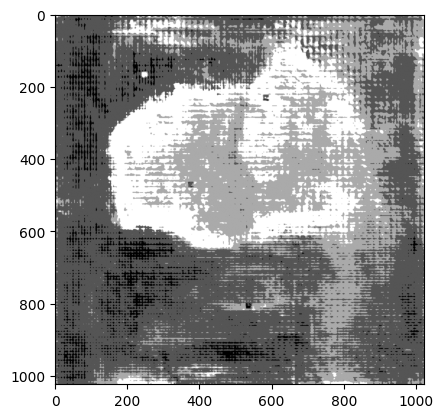

In [106]:
print(output_mask.squeeze().numpy().shape)
plt.imshow(output_mask.squeeze().numpy()*255,cmap = 'gray')

# Hi
